In [ ]:
import torch
import os, glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise
import seaborn as sns

import os, sys
sys.path.insert(0, os.path.abspath('..'))
from data import data_loader
from configs import datasets_config as config
from network import load_model
import network.cb_net as net

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

boiler_path = config.main_path['main'].replace('data', '')
method = 'cb_net'
if not os.path.exists(os.path.join('../graphs', 'decidability', method)):
    os.makedirs(os.path.join('../graphs', 'decidability', method))
    
emb_size = 512
load_model_path = '../models/cb_net/best_model/CB_Net.pth'
model = net.CB_Net(embedding_size = emb_size, do_prob=0.0).eval().to(device)
model = load_model.load_pretrained_network(model, load_model_path, device = device)

## Feature Extraction and Decidability Histogram Plotting Functions

In [2]:
def feature_extractor(model, data_loader, device='cuda:0', peri_flag=False):
    emb = torch.tensor([])
    lbl = torch.tensor([], dtype = torch.int16)

    model = model.eval().to(device)
    
    with torch.no_grad():        
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)
            x = model(x, peri_flag = peri_flag)

            emb = torch.cat((emb, x.detach().cpu()), 0)
            lbl = torch.cat((lbl, y))
            
            del x, y
    
    del data_loader, model
    
    return emb, lbl


def cosine_sim(a, b):
    similarity = torch.matmul(a, b.t())
    # a = np.array(a)
    # b = np.array(b)
    
    return similarity #pairwise.cosine_similarity(a, b)


def dprime(nomatch, match):
    # nomatch = np.histogram(nomatch, bins=512)
    # match = np.histogram(match, bins=512)
    dprime = np.abs(np.mean(match) - np.mean(nomatch)) / np.sqrt(np.power(np.var(match), 2) + np.power(np.var(nomatch), 2))

    return round(dprime, 4)


def same_class_dist(fea, label):
    # same modalities, same class
    same_class_list = torch.tensor([])

    for i in torch.unique(label):
        # get index list where unique labels occur
        peri_indices = np.array(np.where(label == i)).ravel()
        sim_ = torch.Tensor(cosine_sim(fea[peri_indices], fea[peri_indices]).ravel())
        same_class_list = torch.cat((same_class_list, sim_), 0)
        
    return same_class_list


def diff_class_dist(fea, label):
    # same modalities, different class
    diff_class_list = torch.tensor([])

    for i in torch.unique(label):
        # get index list where unique labels occur
        peri_indices = np.array(np.where(label == i)).ravel()
        # indices that are not for label in question (i)
        non_peri_indices = np.array(np.where(label != i)).ravel()
        sim_ = torch.Tensor(cosine_sim(fea[peri_indices], fea[non_peri_indices]).ravel())
        diff_class_list = torch.cat((diff_class_list, sim_), 0)

    return diff_class_list


def inter_model(peri_features, peri_label, face_features, face_label, cls):
    assert torch.all(peri_label == face_label)
    dist = torch.tensor([])

    for i in torch.unique(peri_label):
        peri_indices = np.array(np.where(peri_label == i)).ravel()
        non_peri_indices = np.array(np.where(peri_label != i)).ravel()

        # same classes, different modalities
        if cls == 'intra':
            sims = torch.Tensor(cosine_sim(peri_features[peri_indices], face_features[peri_indices]).ravel())
            dist = torch.cat((dist, sims), 0)
        # different classes, different modalities
        elif cls == 'inter':
            sims1 = torch.Tensor(cosine_sim(peri_features[peri_indices], face_features[non_peri_indices]).ravel())
            sims2 = torch.Tensor(cosine_sim(face_features[peri_indices], peri_features[non_peri_indices]).ravel())
            dist = torch.cat((dist, sims1), 0)
            dist = torch.cat((dist, sims2), 0)

    return dist


def extract(model, data_path, modal):
    if modal[:4] == 'peri':
        peri_flag = True
    else:
        peri_flag = False
    data_load, data_set = data_loader.gen_data(data_path, 'test', type=modal, aug='False')
    feat, labl = feature_extractor(model, data_load, device = device, peri_flag = peri_flag) 

    return feat, labl, data_load, data_set


def plot_hist(inter_class, intra_class, file_name):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({'font.size': 17, 'legend.fontsize': 15})
    dist1, dist2 = np.array(inter_class).ravel(), np.array(intra_class).ravel()

    fig, ax1 = plt.subplots()
    sns.kdeplot(dist1, fill=True, alpha=0.8, label='Inter-Subject', color='#1f77b4', ax=ax1)
    ax1.tick_params(axis ='y', labelcolor = '#1f77b4')
    ax1.set_yticks(np.arange(0, 4, 1))
    ax1.set_xlabel('Cosine Similarity Score')

    ax2 = ax1.twinx()
    sns.kdeplot(dist2, fill=True, alpha=0.8, label='Intra-Subject', color='#ff7f0e', ax=ax2)
    ax2.tick_params(axis ='y', labelcolor = '#ff7f0e')
    ax2.set_yticks(np.arange(0, 4, 1))

    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

    # plt.legend()
    plt.title("$d'$ = %.4f" % (dprime(dist1, dist2)))
    plt.savefig('../graphs/decidability/' + str(file_name) + '.pdf', bbox_inches='tight')

## Extract Features and Calculate Distance

In [3]:
peri = config.main_path['main'] + '/visualization/decidability/peri/'
face = config.main_path['main'] + '/visualization/decidability/face/'

peri_fea, peri_label, peri_data_load, peri_data_set = extract(model, peri, 'peri')
face_fea, face_label, face_data_load, face_data_set = extract(model, face, 'face')

# p-peri,f-face,cm-cross modal. intra-similar,inter-different. m-modality,c-class/subject
p_intra_m_intra_c = same_class_dist(peri_fea, peri_label)
p_intra_m_inter_c = diff_class_dist(peri_fea, peri_label)
f_intra_m_intra_c = same_class_dist(face_fea, face_label)    
f_intra_m_inter_c = diff_class_dist(face_fea, face_label)
cm_inter_m_intra_c = inter_model(peri_fea, peri_label, face_fea, face_label, cls='intra')
cm_inter_m_inter_c = inter_model(peri_fea, peri_label, face_fea, face_label, cls='inter')

## Plot Graph

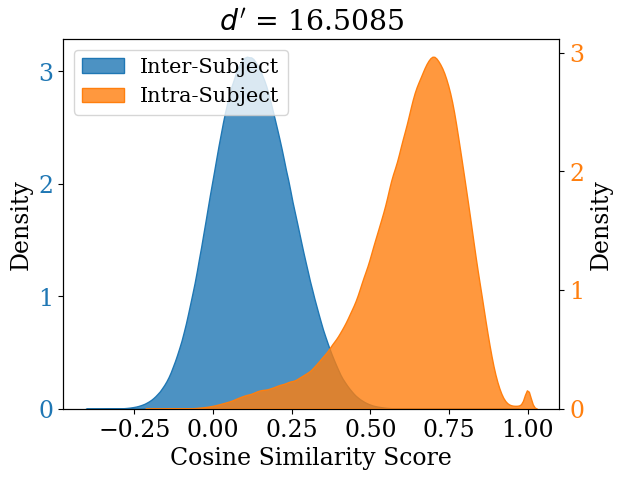

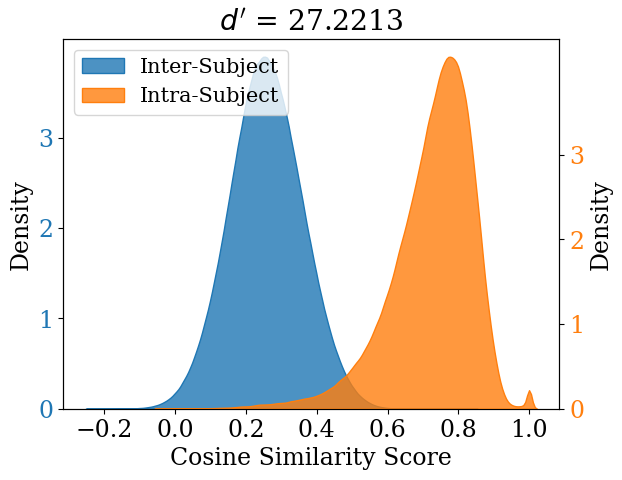

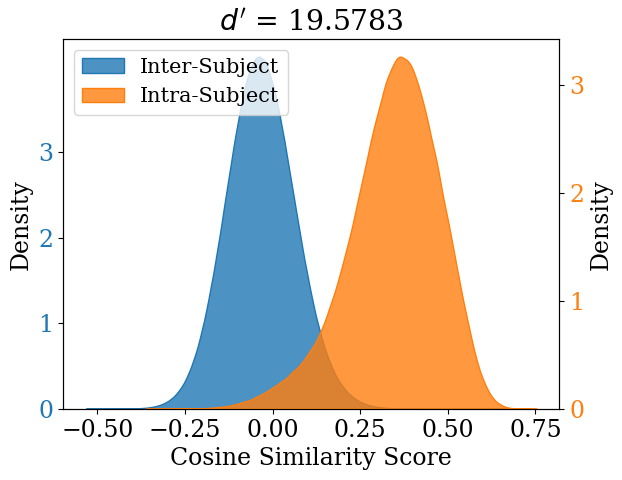

In [4]:
# Periocular
plot_hist(p_intra_m_inter_c, p_intra_m_intra_c, str(method) + '/peri')
# Face
plot_hist(f_intra_m_inter_c, f_intra_m_intra_c, str(method) + '/face')
# Cross-Modal
plot_hist(cm_inter_m_inter_c, cm_inter_m_intra_c, str(method) + '/cross')